# Application: Deforestation Analysis using Color Segmentation

This notebook will help you learn about an application of Color Segmentation using OpenCV. You will learn some important lessons using some simple examples. In this notebook, you will learn the following:

* Analyzing image using Histograms
* Segmenting a particular color range in an image and creating a mask in both RGB and HSV space
* Build a simple application for analyzing satellite imagery 

**NOTE**: The satellite images can be obtained from various sources. To keep things simple, in this example we have taken images from the Google Earth Engine from a certain region in Cancun, Mexico. 

In [1]:
import cv2 
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/s1bc9bnavqx9ryo/AABFVq9q_73nOcZ4T05k40rga?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    %cd Applications
else:
    pass

module-code.zip     100%[===================>]  86.50M  35.9MB/s    in 2.4s    
mapname:  conversion of  failed
/content/Applications


# 1. Read Images
We will use images from year 1985, 1993, 2001 and 2011 in this example. Let us read the images and see how much difference we can perceive.

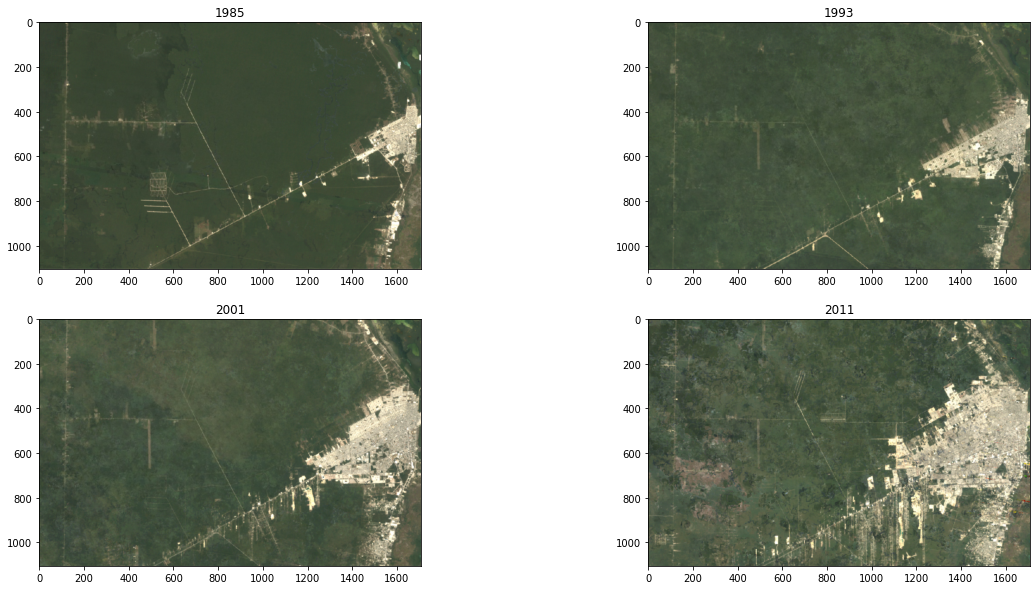

In [ ]:
# Reading first screenshot.
image1 = cv2.imread('Images/1985.png')
image2 = cv2.imread('Images/1993.png')
image3 = cv2.imread('Images/2001.png')
image4 = cv2.imread('Images/2011.png')


fig = plt.figure(figsize=[20, 10])

ax = fig.add_subplot(2, 2, 1)
ax.set_title('1985')
plt.imshow(image1[:, :, ::-1])

ax = fig.add_subplot(2, 2, 2)
ax.set_title('1993')
plt.imshow(image2[:, :, ::-1])

ax = fig.add_subplot(2, 2, 3)
ax.set_title('2001')
plt.imshow(image3[:, :, ::-1])

ax = fig.add_subplot(2, 2, 4)
ax.set_title('2011')
plt.imshow(image4[:, :, ::-1])

# 2. View Channels
We can see that most of the image is green, with patches of creamy-white color. Also, the shade of green keeps changing over years. How do we find the forest area? Let us visualize the different channels.

We will check the channels for the year 1985 and 2011.

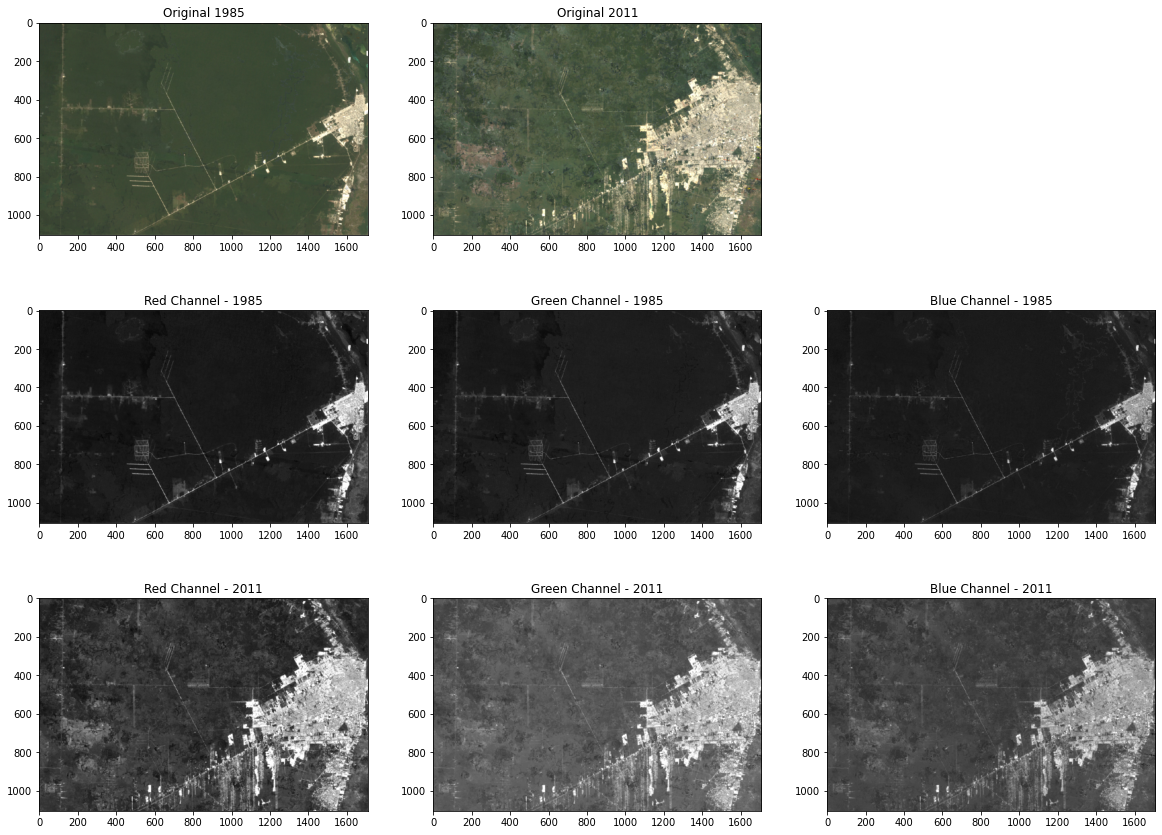

In [ ]:
b1, g1, r1 = cv2.split(image1)
b4, g4, r4 = cv2.split(image4)

# Show the channels.
plt.figure(figsize = [20, 15])
plt.subplot(331); plt.imshow(image1[:, :, ::-1]); plt.title('Original 1985')
plt.subplot(332); plt.imshow(image4[:, :, ::-1]); plt.title('Original 2011')

plt.subplot(334); plt.imshow(r1); plt.title('Red Channel - 1985')
plt.subplot(335); plt.imshow(g1); plt.title('Green Channel - 1985')
plt.subplot(336); plt.imshow(b1); plt.title('Blue Channel - 1985')

plt.subplot(337); plt.imshow(r4); plt.title('Red Channel - 2011')
plt.subplot(338); plt.imshow(g4); plt.title('Green Channel - 2011')
plt.subplot(339); plt.imshow(b4); plt.title('Blue Channel - 2011')

If you look at the green channels of 1985, it is dark in the areas of forest and for 2011, the green channel is a little brighter as compared to the 1985 one. So, to find the green area, one way would be to apply a threshold on the green channel and check the results iteratively until you find the results are satisfactory. But that would be time consuming and error-prone. A better way would be to check the histogram to find out the range of values for the particular color that we want to segment. Let us have a look at the histograms.

# 3. Find Image Histograms
As we saw in the previous section, we will use calcHist() function to compute the histograms for each channel of the image. Since all of the images are BGR format, we will use 256 bins and plot the same. Let's see how it looks.

## 3.1 Plotting linear and logarithmic histograms

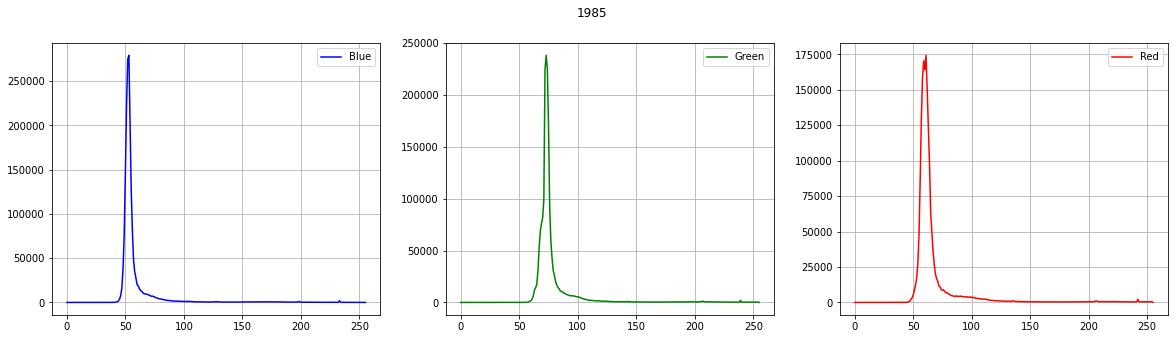

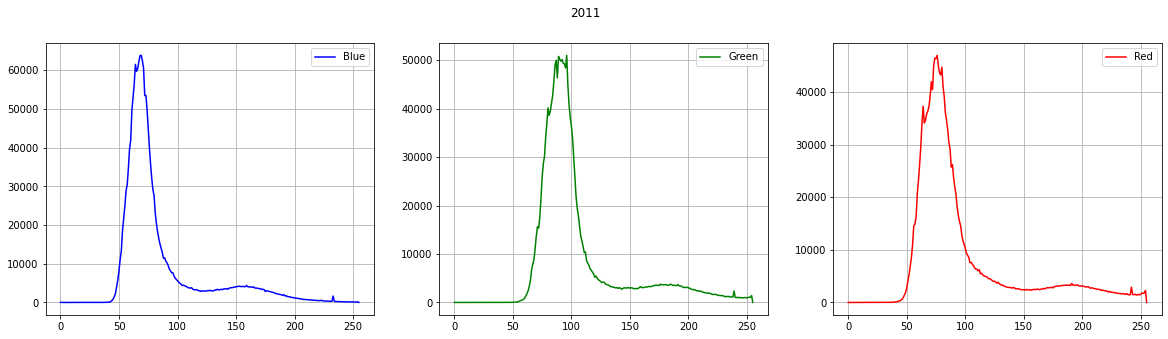

In [ ]:
def draw_image_histogram_bgr(image, title = '', yscale = 'linear'):
    """Utility to plot bgr histograms for all color channels independently."""
    histB = cv2.calcHist([image], [0], None, [256], [0, 255])
    histG = cv2.calcHist([image], [1], None, [256], [0, 255])
    histR = cv2.calcHist([image], [2], None, [256], [0, 255])
    
    # Plot the histograms for each channel.
    fig = plt.figure(figsize = [20, 5])
    fig.suptitle(title)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.set_yscale(yscale)
    plt.plot(histB, color = 'b', label = 'Blue')
    ax.grid()
    ax.legend()
    
    ax = fig.add_subplot(1, 3, 2)
    ax.set_yscale(yscale)
    plt.plot(histG, color = 'g', label = 'Green')
    ax.grid()
    ax.legend()
    
    ax = fig.add_subplot(1, 3, 3)
    ax.set_yscale(yscale)
    plt.plot(histR, color = 'r', label = 'Red')
    ax.grid()
    ax.legend()
    
    plt.show()

# Calculate and draw the histograms for the images.
draw_image_histogram_bgr(image1, '1985')
draw_image_histogram_bgr(image4, '2011')

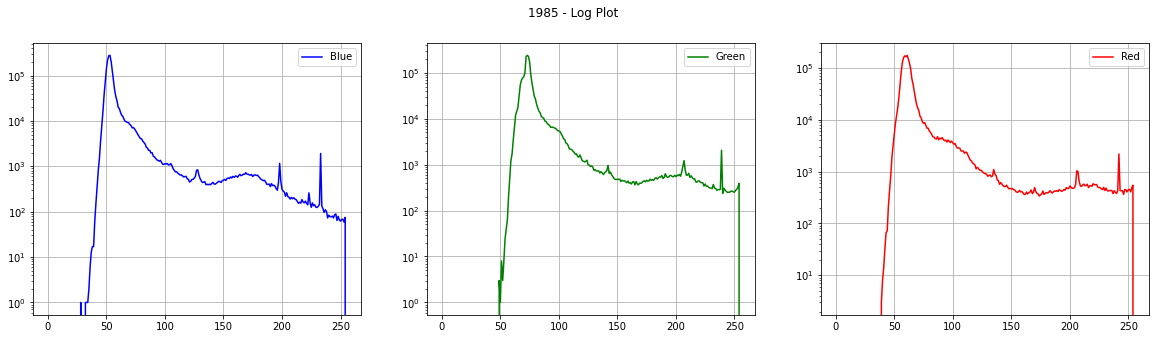

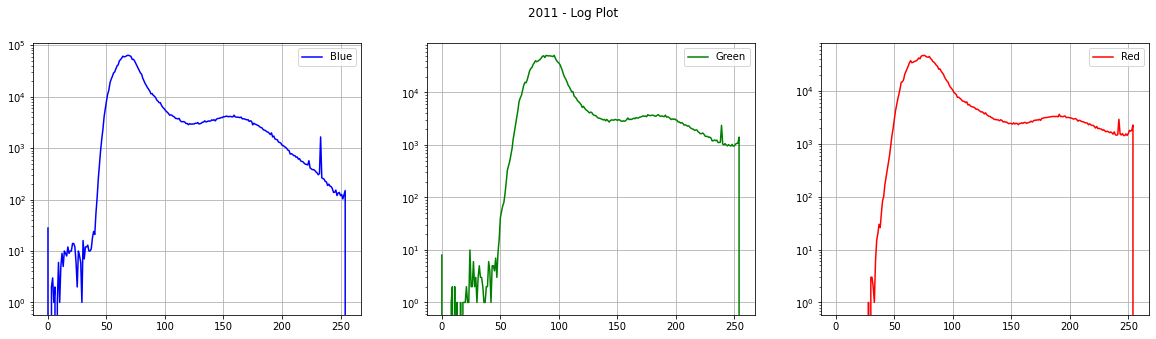

In [ ]:
# Display the Log plots.
draw_image_histogram_bgr(image1,'1985 - Log Plot', 'log')
draw_image_histogram_bgr(image4,'2011 - Log Plot', 'log')

## 3.1. Conclusion
We can see from the 1985 plot that there is a huge peak around the intensity value of ~60 and that most of the values lie in the range 50 to 80. The range is much wider in case of 2011.

It is worth checking the Log plot as that gives us an indication that the values after the peaks are not zero (the linear plot gives an impression that all values after the peak is zero).

The second observation comes from the 2011 histogram: you can see a second, smaller peak around the intensity value of ~190. This belongs to the bright "port" region on the right.

Now that we have the histograms that show the range of values that belongs to the green channel, we can use them to segment the image and find the forest cover for each image.

# 4. Color Segmentation using inRange
We will use the function `inRange` to find out the mask for the green color from the image.

<hr   style="border:none; height: 4px; background-color: #D3D3D3 " />

**`inRange()`** Creates a mask on the basis of color values.

### <font style="color:rgb(8,133,37)">Function Syntax </font>
``` 
dst = cv2.inRange(src, lowerb, upperb[, dst]) 
```

`dst`: the output array of the same size as src and CV_8U type.

The function has **3 required arguments**:

1. `src`: first input array.
2. `lowerb`: inclusive lower boundary array or a scalar.
3. `upperb`: inclusive upper boundary array or a scalar.

### <font style="color:rgb(8,133,37)">OpenCV Documentation</font>

[**`inRange()`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981)

<hr   style="border:none; height: 4px; background-color: #D3D3D3 " />

You should play around with the values that we have used and see the results.

In [ ]:
def detect_green_BGR(img):
    """Detect and return a mask for the green area of an image using BGR segmentation."""
    lower_BGR_values = np.array([0, 50, 0], dtype = 'uint8')
    upper_BGR_values = np.array([255, 100, 255], dtype = 'uint8')
    
    # Create a mask using the lower and upper range.
    mask_BGR = cv2.inRange(img, lower_BGR_values, upper_BGR_values) 

    return mask_BGR

# 5. Detect and Plot Segmented Output
We will display the results for the segmentation obtained using the above function.

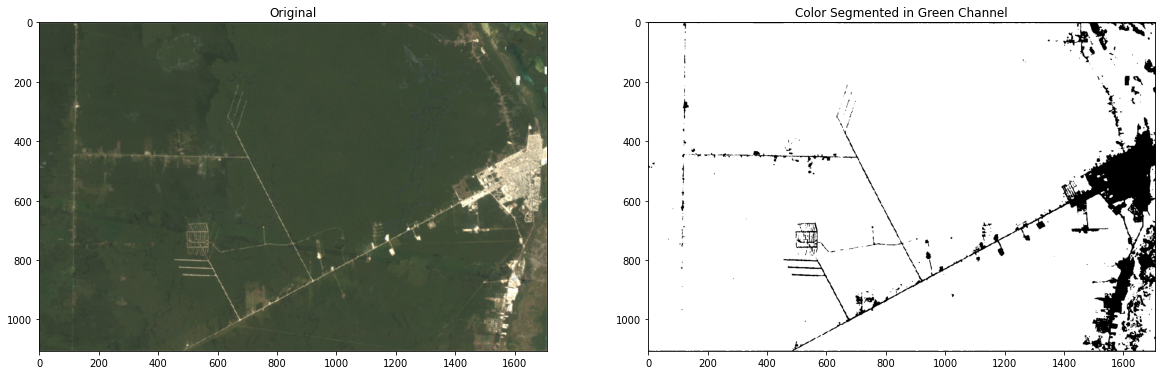

In [ ]:
segmented_green = detect_green_BGR(image1)

fig = plt.figure(figsize = (20, 10))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(image1[:, :, ::-1])
ax.set_title('Original')

ax = fig.add_subplot(1, 2, 2)
plt.imshow(segmented_green, cmap = 'gray')
ax.set_title('Color Segmented in Green Channel')

plt.show()

We can see that the green regions are very well segmented as desired. Now, let us find the percentage of the green region in the image.

# 6. Find percentage of non-zero pixels
We will use this function to compute the percentage of green pixels in the image. We use the function `countNonZero` to find the non zero pixels and then divide the number with the total number of pixels in the image. This gives us the percentage of non-zero pixels in the image.

In [ ]:
def percent_forest(gray_img):
    """Return the percentage of the image detected to be forested."""
    c = cv2.countNonZero(gray_img)

    # Finding number of pixels in image to find percentage.
    t = gray_img.shape[0] * gray_img.shape[1]

    # Rounding off to 2 decimal place.
    return round((c / t) * 100, 2)

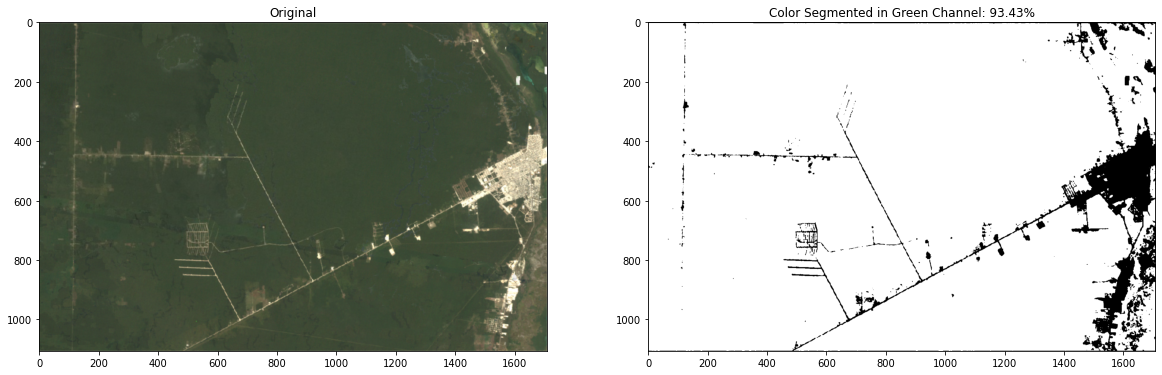

In [ ]:
segmented_green = detect_green_BGR(image1)
green_ratio = percent_forest(segmented_green)

fig = plt.figure(figsize = (20, 20))

ax = fig.add_subplot(1, 2, 1)
plt.imshow(image1[:, :, ::-1])
ax.set_title('Original')

ax = fig.add_subplot(1, 2, 2)
plt.imshow(segmented_green, cmap = 'gray')
ax.set_title('Color Segmented in Green Channel: ' + str(green_ratio) + '%')

plt.show()

# 7. Check for all images
Now, let us check the percentage greenery in some more images. We will use 4 images taken from 1985, 1993, 2001, and 2011. 

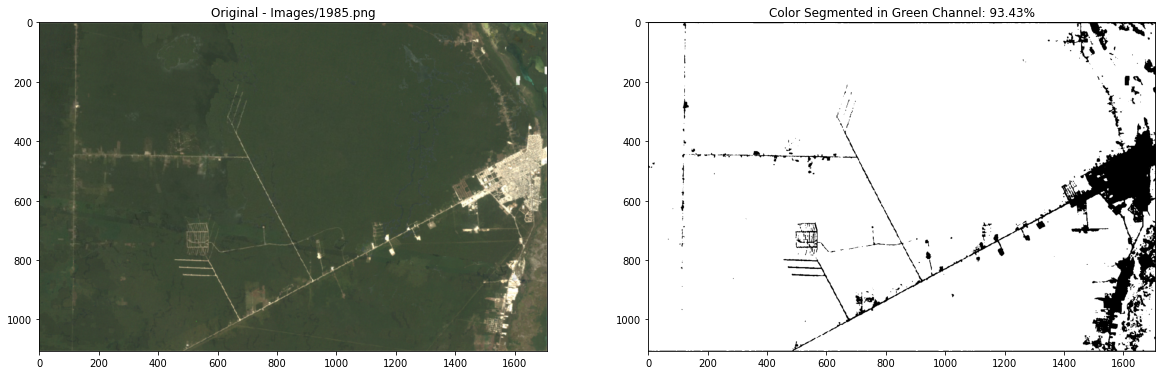

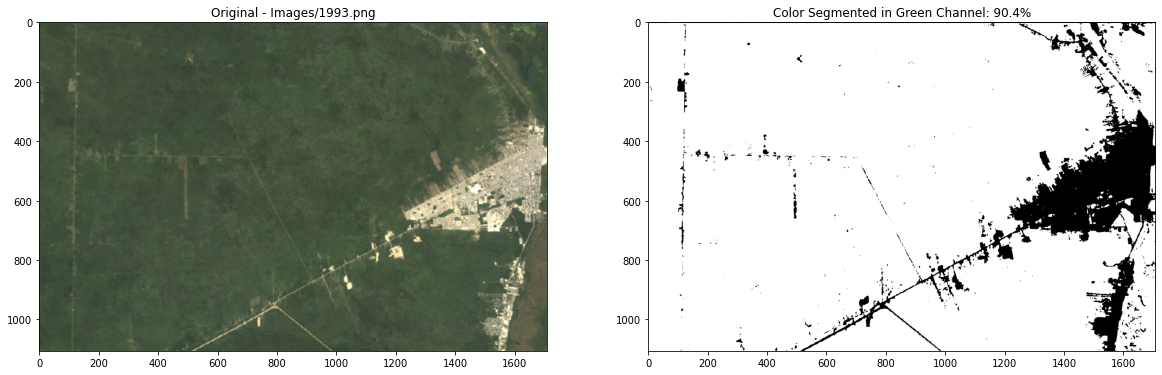

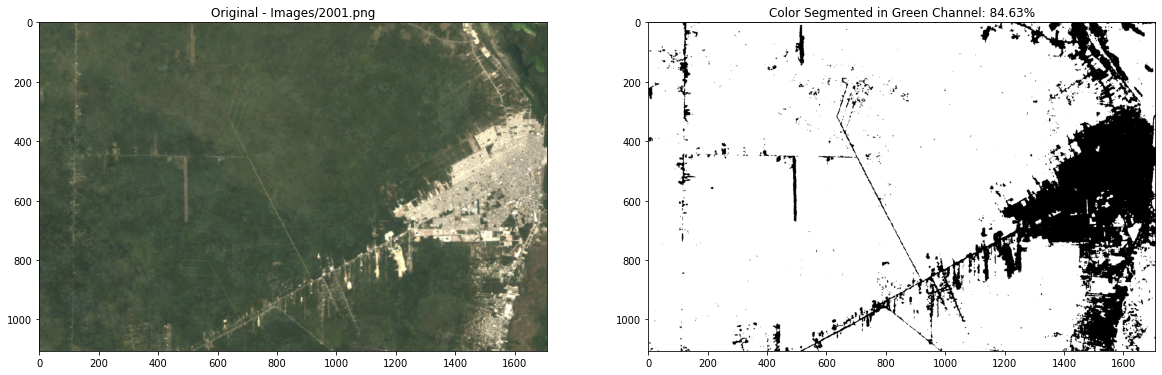

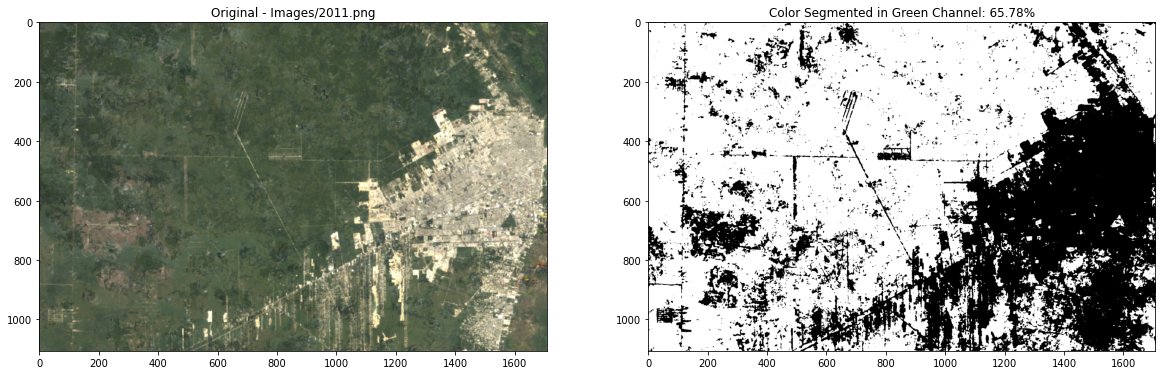

In [ ]:
image_files = glob.glob("Images/*.png")
image_files.sort()
for image_file in image_files: 
    image = cv2.imread(image_file)
    
    segmented_green = detect_green_BGR(image)
    green_ratio = percent_forest(segmented_green)

    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(image[:, :, ::-1])
    ax.set_title('Original - ' + image_file)
    
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(segmented_green, cmap = 'gray')
    ax.set_title('Color Segmented in Green Channel: ' + str(green_ratio) + '%')
    
    plt.show()

# 8. Analysis using the HSV Color Space

Another approach to this segmentation problem is to use the HSV color space to isolate the range of hue values representing the forested areas.

In [ ]:
def draw_image_histogram_hsv(image, title = '', yscale = 'linear'):
    """Utility to plot histograms for the hue, saturation, value channels independently."""
    HSV_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    histH = cv2.calcHist([HSV_image], [0], None, [180], [0, 179])
    histS = cv2.calcHist([HSV_image], [1], None, [256], [0, 255])
    histV = cv2.calcHist([HSV_image], [2], None, [256], [0, 255])
    
    # Plot the histograms for each channel.
    fig = plt.figure(figsize = [20, 5])
    fig.suptitle(title)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.set_yscale(yscale)
    plt.plot(histH, color = 'b', label = 'Hue')
    ax.grid()
    ax.legend()
    
    ax = fig.add_subplot(1, 3, 2)
    ax.set_yscale(yscale)
    plt.plot(histS, color = 'g', label = 'Saturation')
    ax.grid()
    ax.legend()
    
    ax = fig.add_subplot(1, 3, 3)
    ax.set_yscale(yscale)
    plt.plot(histV, color = 'r', label = 'Value')
    ax.grid()
    ax.legend()
    
    plt.show()

## 8.1. Detect Segmented area from HSV Image

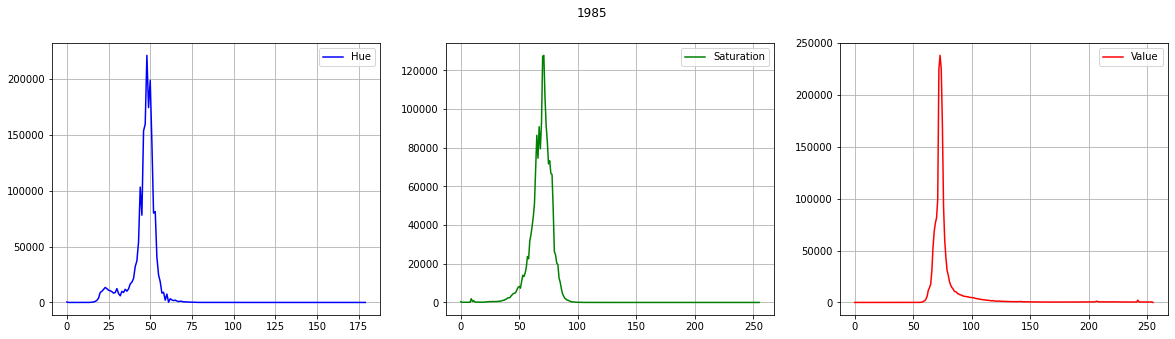

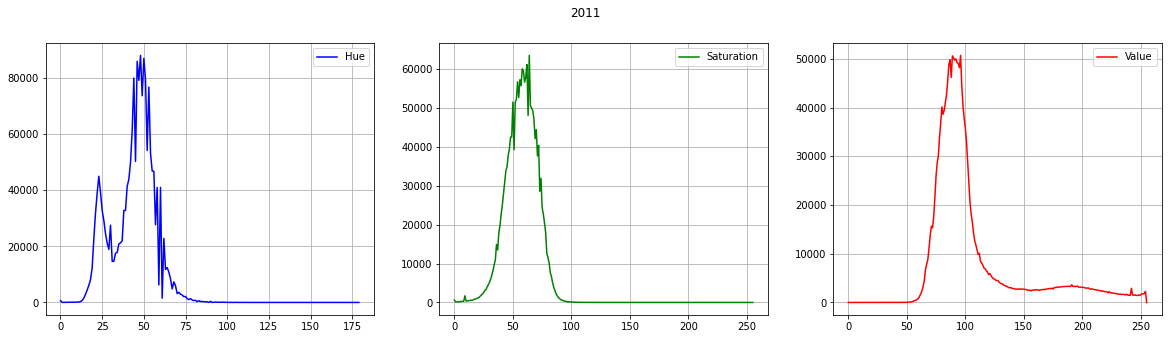

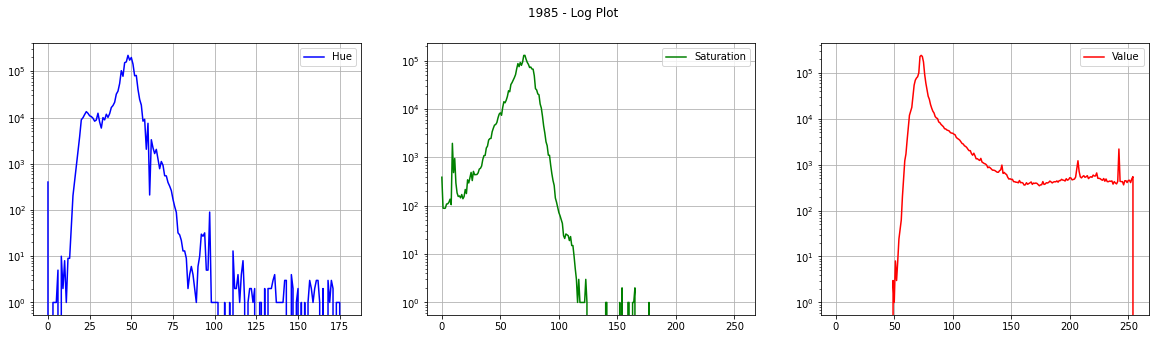

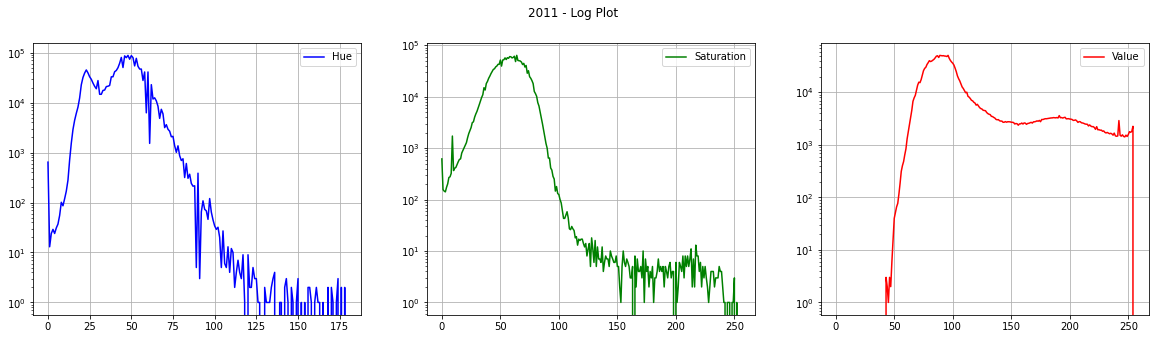

In [ ]:
# calculate and draw the histograms for the images
draw_image_histogram_hsv(image1, '1985')
draw_image_histogram_hsv(image4, '2011')

# Display the Log plots
draw_image_histogram_hsv(image1, '1985 - Log Plot','log')
draw_image_histogram_hsv(image4, '2011 - Log Plot','log')
    

## 8.2. Compute and compare with BGR 

In [ ]:
def detect_green_HSV(img):
    """Detect and return a mask for the green area of an image using HSV segmentation."""
    HSV_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    lower_HSV_values = np.array([36, 0, 50], dtype = 'uint8')
    upper_HSV_values = np.array([86, 250, 100], dtype = 'uint8')
    
    mask_HSV = cv2.inRange(HSV_image, lower_HSV_values, upper_HSV_values) 
    
    return mask_HSV

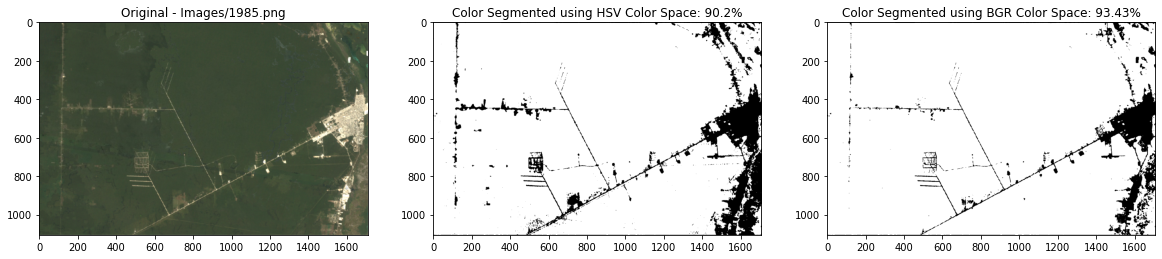

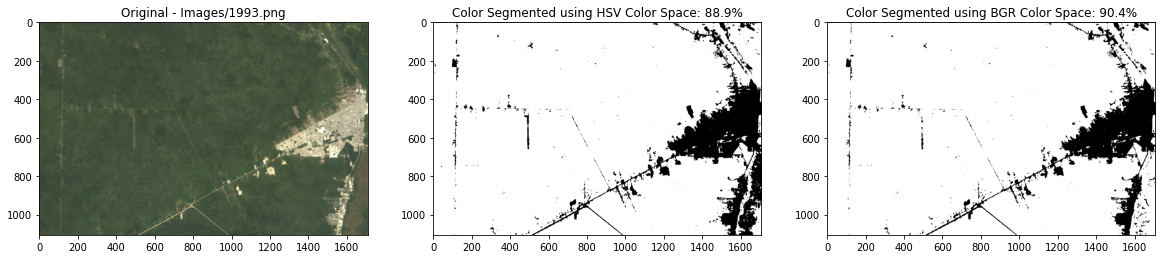

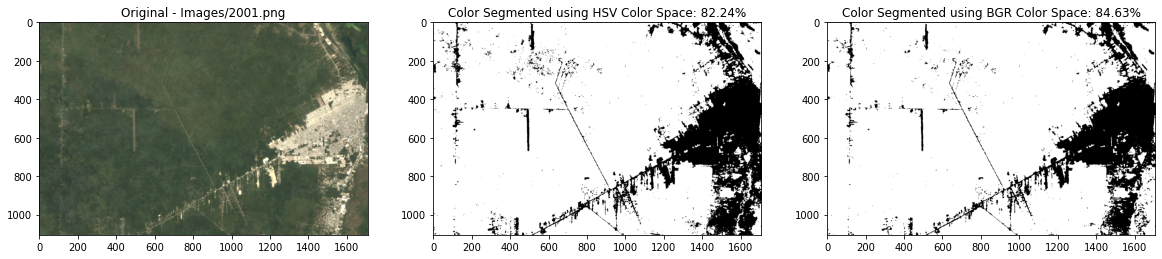

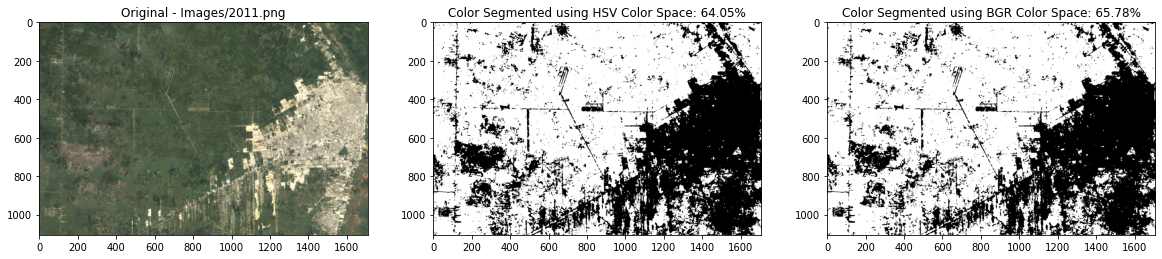

In [ ]:
image_files = glob.glob("Images/*.png")
image_files.sort()
for image_file in image_files: 
    image = cv2.imread(image_file)
    
    segmented_green_hsv = detect_green_HSV(image)
    green_ratio_hsv = percent_forest(segmented_green_hsv)
    
    segmented_green_bgr = detect_green_BGR(image)
    green_ratio_bgr = percent_forest(segmented_green_bgr)

    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(1, 3, 1)
    plt.imshow(image[:, :, ::-1])
    ax.set_title('Original - ' + image_file)
    
    ax = fig.add_subplot(1, 3, 2)
    plt.imshow(segmented_green_hsv, cmap = 'gray')
    ax.set_title('Color Segmented using HSV Color Space: ' + str(green_ratio_hsv) + '%')
    
    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(segmented_green_bgr, cmap = 'gray')
    ax.set_title('Color Segmented using BGR Color Space: ' + str(green_ratio_bgr) + '%')
    
    plt.show()

# 9. Conclusion

The results obtained with simple color segmentation techniques are quite good.

It is always better to do a thorough analysis of the data that you are working with before coming up with the final solution. In this case, looking at the histogram plot gave us a good idea about the thresholds to be used. 

Finally, the BGR color space is totally dependent on the intensity values, so all channels are correlated to an extent. However, the HSV color space has clear distinguishing features among the channels. This gives us fine-grained control over the values that we want to use. You should try checking both HSV and BGR color spaces for doing any color based segmentation on your project.